# **Multi-Letter Image Classification with Convolutional Neural Networks (CNNs) using PyTorch**

In this Jupyter Notebook, we extend the idea of **Convolutional Neural Networks (CNNs)** for image classification, building upon concepts from **"Neural Networks Part 8: Image Classification with Convolutional Neural Networks (CNNs)"** (StatQuest by Josh Starmer). However, we will:

- Create **more letters** (beyond just X and O) with **better-drawn shapes** in a larger 10x10 grid.
- Demonstrate how convolution, ReLU activations, and pooling layers work in **PyTorch**.
- Train a CNN to classify these letters even when they are **randomly shifted**.

We'll use four letters for illustration:
1. **O**: approximated with a circle-like border.
2. **X**: two diagonal lines.
3. **T**: a top horizontal bar and a vertical stroke down the center.
4. **S**: shaped like a snake-like curve.

After generating these images at **10x10** resolution, we'll randomly shift each image by up to **2 pixels** to illustrate the translation-invariance capabilities of CNNs.

---

## **Notebook Outline**
1. [Introduction to CNNs](#section1)
2. [Import Libraries](#section2)
3. [Create a Synthetic Multi-Letter Dataset (O, X, T, S)](#section3)
4. [Data Visualization](#section4)
5. [Build and Train a CNN in PyTorch](#section5)
6. [Evaluate the Model](#section6)
7. [Conclusion](#section7)
8. [References](#section8)


## 1. Introduction to CNNs

Convolutional Neural Networks (CNNs) are specialized architectures for processing data with a known, grid-like topology (e.g., images). Their key innovations are:

1. **Convolutional Layers**: A filter (or kernel) slides across the image, computing a dot product between the filter weights and local regions of the image (a process called "convolution"). This exploits **local connectivity** and greatly reduces the number of parameters compared to a fully-connected network:

$$\text{Output}[i, j] = \sum_{m,n} (\text{Filter}[m,n] \times \text{Input}[i+m, j+n]) + b$$

2. **Activation Functions** (often **ReLU**):

$$\text{ReLU}(z) = \max(0, z)$$

   ReLU makes training faster and helps mitigate the **vanishing gradient** problem better than logistic or tanh.

3. **Pooling Layers**: They **reduce** the spatial dimension (e.g., 2x2 max-pooling) while retaining the most important feature responses:

$$\text{MaxPool}\big(\{x_1, x_2, ..., x_k\}\big) = \max(x_1, x_2, ..., x_k)$$

4. **Fully Connected Layers**: At the end of the convolutional stack, the feature maps are flattened and passed to one or more fully connected (dense) layers for classification.

These concepts allow CNNs to:

- **Capture local correlations** in images.
- Be **translation-invariant** or robust to shifts in the image.
- Significantly **reduce** the number of trainable parameters.

---

## 2. Import Libraries

Here we import all the Python libraries that we will use in this tutorial.

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


## 3. Create a Synthetic Multi-Letter Dataset (O, X, T, S)

We will create synthetic **10x10** grayscale images for the letters: **O**, **X**, **T**, and **S**. Each letter will be drawn in a distinct shape. We will represent black pixels with **1** and white pixels with **0**, similar to the discussion in the video. Each image is stored as a **2D NumPy array**, then converted to PyTorch tensors.

We will also **randomly shift** each image by up to **2 pixels** in any direction, to test the model's robustness to small translations.

### 3.1 Helper Functions to Draw Each Letter
- **O**: Approximate a circle of radius ~3 or 4 in the 10x10 grid.
- **X**: Two thicker diagonals.
- **T**: Horizontal line on top + vertical line from top-center downward.
- **S**: A snake-like or curvy shape.


In [2]:
def draw_O(size=10):
    """Generate a 10x10 image with an O shape approximated by a circular boundary."""
    img = np.zeros((size, size), dtype=np.float32)
    center = size // 2
    radius = 3.5  # slightly smaller than half

    # We'll draw a circle boundary using (x - cx)^2 + (y - cy)^2 ~ radius^2
    for i in range(size):
        for j in range(size):
            dist_sq = (i - center)**2 + (j - center)**2
            # We'll set a band for the circle boundary
            if (radius - 0.8)**2 <= dist_sq <= (radius + 0.8)**2:
                img[i, j] = 1.0
    return img

def draw_X(size=10):
    """Generate a 10x10 image with a thicker X shape."""
    img = np.zeros((size, size), dtype=np.float32)
    thickness = 2
    for i in range(size):
        for j in range(size):
            # Main diagonal => i == j
            # Secondary diagonal => i + j == size - 1
            if abs(i - j) < thickness or abs((i + j) - (size - 1)) < thickness:
                img[i, j] = 1.0
    return img

def draw_T(size=10):
    """Generate a 10x10 image with a T shape (top bar + vertical line)."""
    img = np.zeros((size, size), dtype=np.float32)
    # Horizontal bar near the top
    img[1, :] = 1.0  # row 1
    # Thicken the bar
    img[2, :] = 1.0

    # Vertical line in the center
    col_center = size // 2
    for row in range(3, size - 1):
        img[row, col_center] = 1.0
    return img

def draw_S(size=10):
    """Generate a 10x10 image with an S or curve shape."""
    img = np.zeros((size, size), dtype=np.float32)

    # We'll place a sinusoidal curve:
    # row = function of col
    # For example: row = 2 + int(2*sin(col/2)) + col//3
    for col in range(size):
        # We'll shift and add some wave
        row = int(3 + 2 * np.sin(col / 2.0) + col * 0.2)
        if 0 <= row < size:
            img[row, col] = 1.0
        # Thicken the S
        if row + 1 < size:
            img[row+1, col] = 1.0
        if row - 1 >= 0:
            img[row-1, col] = 1.0
    return img

### 3.2 Random Shift Function
We'll create a helper to shift the image by up to `max_shift` pixels in any direction.

In [3]:
def random_shift(img, max_shift=2):
    """Shift the image up/down/left/right by up to max_shift pixels."""
    size = img.shape[0]
    shift_x = random.randint(-max_shift, max_shift)
    shift_y = random.randint(-max_shift, max_shift)
    shifted = np.zeros_like(img)
    for i in range(size):
        for j in range(size):
            new_i = i + shift_x
            new_j = j + shift_y
            if 0 <= new_i < size and 0 <= new_j < size:
                shifted[new_i, new_j] = img[i, j]
    return shifted

### 3.3 Generate Dataset
We will generate 500 samples per letter class. In total, we will have 4 classes (O, X, T, S) => 2000 images.

In [38]:
num_samples_per_class = 500  # Number of images per class
size = 10                   # Image size 10x10

letters = ['O', 'X', 'T', 'S']
label_map = { 'O': 0, 'X': 1, 'T': 2, 'S': 3 }

data = []
labels = []

for letter in letters:
    for _ in range(num_samples_per_class):
        if letter == 'O':
            img = draw_O(size)
        elif letter == 'X':
            img = draw_X(size)
        elif letter == 'T':
            img = draw_T(size)
        elif letter == 'S':
            img = draw_S(size)
        # Random shift
        img_shifted = random_shift(img, max_shift=2)
        data.append(img_shifted)
        labels.append(label_map[letter])

data = np.array(data)
labels = np.array(labels)

print("Data shape:", data.shape)    # (2000, 10, 10)
print("Labels shape:", labels.shape) # (2000,)

Data shape: (2000, 10, 10)
Labels shape: (2000,)


## 4. Data Visualization

We'll plot some samples from the dataset to see how the letters (O, X, T, S) appear (with random shifts). We'll plot them in a grid with a color map that highlights the black (1) vs. white (0) pixels.

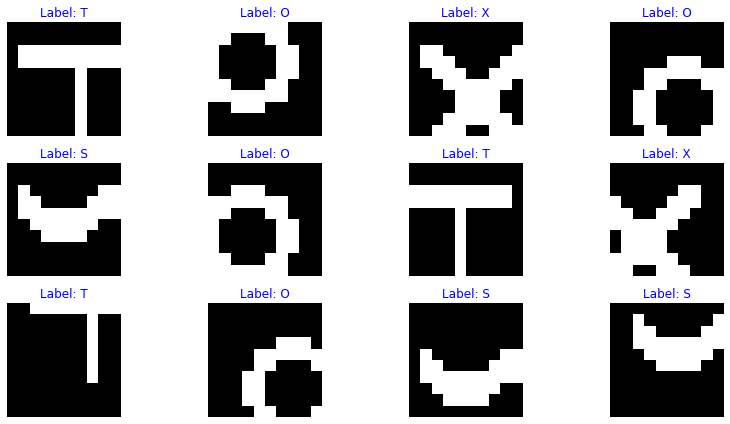

In [41]:
# Let's plot a few random examples
plt.figure(figsize=(12, 6))
for i in range(12):
    idx = random.randint(0, len(data)-1)
    plt.subplot(3, 4, i+1)
    plt.imshow(data[idx], cmap='gray', vmin=0, vmax=1)
    # Convert label back to letter
    for k, v in label_map.items():
        if v == labels[idx]:
            letter = k
            break
    plt.title(f"Label: {letter}", color="blue")
    plt.axis('off')

plt.tight_layout()
plt.show()

### 4.1 Prepare Data for Training

We'll split the dataset into training and test sets using scikit-learn's `train_test_split`. We also need to convert everything into **PyTorch tensors**. Since these are grayscale images, we have **1 channel**.

Shape expected by a PyTorch CNN is typically: `(batch_size, channels, height, width)`.

In [42]:
# Expand dims to (batch, 1, height, width)
data_expanded = np.expand_dims(data, axis=1).astype(np.float32)

# Train/test split
X_train_np, X_test_np, y_train_np, y_test_np = train_test_split(
    data_expanded,
    labels,
    test_size=0.2,
    random_state=42,
    stratify=labels  # Keep class distribution consistent
)

print("Training data shape:", X_train_np.shape) # (1600, 1, 10, 10)
print("Testing data shape:\t", X_test_np.shape)  # (400, 1, 10, 10)

num_classes = 4  # O, X, T, S

Training data shape: (1600, 1, 10, 10)
Testing data shape:	 (400, 1, 10, 10)


### 4.2 Build a Custom PyTorch Dataset
We'll define a custom dataset to handle indexing and transformations if needed.

In [43]:
class LettersDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = torch.tensor(self.images[idx], dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return image, label

train_dataset = LettersDataset(X_train_np, y_train_np)
test_dataset  = LettersDataset(X_test_np, y_test_np)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=16, shuffle=False)


## 5. Build and Train a CNN in PyTorch

We will build a simple CNN with two convolutional layers:

1. **Conv2D** with (in_channels=1, out_channels=6, kernel_size=3) + ReLU + **MaxPool2D(kernel_size=2)**
2. **Conv2D** with (in_channels=6, out_channels=12, kernel_size=3) + ReLU + **MaxPool2D(kernel_size=2)**
3. Flatten and connect to **Linear(num_features=12, out_features=4)**

Given our 10x10 images, let's check the dimension flow:
- After first conv (kernel=3) => output: (batch, 6, 8, 8)
- After first maxpool (2x2) => output: (batch, 6, 4, 4)
- After second conv (kernel=3) => output: (batch, 12, 2, 2)
- After second maxpool (2x2) => output: (batch, 12, 1, 1)
- Flatten => (batch, 12)
- Linear => (batch, 4)


In [44]:
class MultiLetterCNN(nn.Module):
    def __init__(self, num_classes=4):
        super(MultiLetterCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=3)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        # after pool2 => (batch, 12, 1, 1)
        self.fc = nn.Linear(12 * 1 * 1, num_classes)

    def forward(self, x):
        x = self.conv1(x)  # (batch, 6, 8, 8)
        x = F.relu(x)
        x = self.pool1(x)  # (batch, 6, 4, 4)

        x = self.conv2(x)  # (batch, 12, 2, 2)
        x = F.relu(x)
        x = self.pool2(x)  # (batch, 12, 1, 1)

        x = x.view(x.size(0), -1)  # flatten => (batch, 12)
        x = self.fc(x)            # => (batch, num_classes)
        return x

### 5.1 Initialize Model, Loss, and Optimizer

In [45]:
model = MultiLetterCNN(num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print(model)

MultiLetterCNN(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 12, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=12, out_features=4, bias=True)
)


### 5.2 Training Loop

We train for a few epochs and track the loss and accuracy on both the training and test sets.

In [46]:
num_epochs = 10

train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

for epoch in range(num_epochs):
    # Training
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = 100.0 * correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    # Validation (test set)
    model.eval()
    test_running_loss = 0.0
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            test_running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            test_correct += (predicted == labels).sum().item()
            test_total += labels.size(0)

    test_epoch_loss = test_running_loss / len(test_loader.dataset)
    test_epoch_acc = 100.0 * test_correct / test_total
    test_losses.append(test_epoch_loss)
    test_accuracies.append(test_epoch_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] - "
          f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.2f}% | "
          f"Test Loss: {test_epoch_loss:.4f}, Test Acc: {test_epoch_acc:.2f}%")

Epoch [1/10] - Train Loss: 1.3661, Train Acc: 25.69% | Test Loss: 1.3127, Test Acc: 37.00%
Epoch [2/10] - Train Loss: 1.1945, Train Acc: 73.44% | Test Loss: 0.9819, Test Acc: 89.25%
Epoch [3/10] - Train Loss: 0.6989, Train Acc: 93.56% | Test Loss: 0.4105, Test Acc: 97.50%
Epoch [4/10] - Train Loss: 0.2809, Train Acc: 98.25% | Test Loss: 0.1608, Test Acc: 99.00%
Epoch [5/10] - Train Loss: 0.1104, Train Acc: 100.00% | Test Loss: 0.0647, Test Acc: 100.00%
Epoch [6/10] - Train Loss: 0.0470, Train Acc: 100.00% | Test Loss: 0.0329, Test Acc: 100.00%
Epoch [7/10] - Train Loss: 0.0258, Train Acc: 100.00% | Test Loss: 0.0203, Test Acc: 100.00%
Epoch [8/10] - Train Loss: 0.0165, Train Acc: 100.00% | Test Loss: 0.0136, Test Acc: 100.00%
Epoch [9/10] - Train Loss: 0.0115, Train Acc: 100.00% | Test Loss: 0.0099, Test Acc: 100.00%
Epoch [10/10] - Train Loss: 0.0085, Train Acc: 100.00% | Test Loss: 0.0075, Test Acc: 100.00%


### 5.3 Plot Training and Validation History

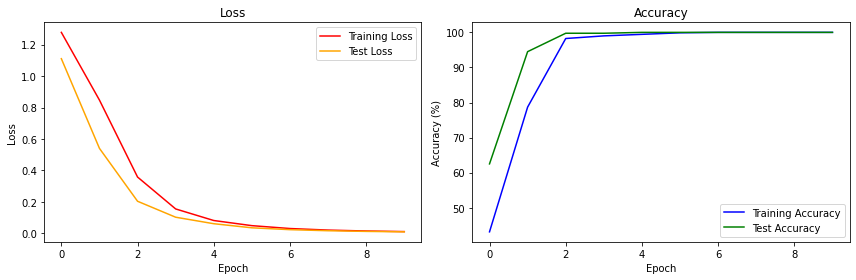

In [27]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss', color='red')
plt.plot(test_losses, label='Test Loss', color='orange')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy', color='blue')
plt.plot(test_accuracies, label='Test Accuracy', color='green')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

## 6. Evaluate the Model

We'll check our model's performance on the entire test set and display a quick **confusion matrix** to see how well it distinguishes **O, X, T,** and **S**.

Final Test Accuracy = 100.00%


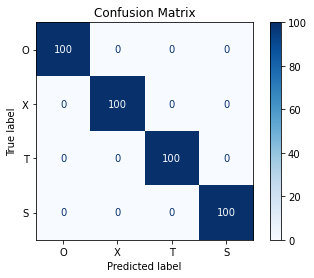

In [28]:
model.eval()
test_correct = 0
test_total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        test_correct += (predicted == labels).sum().item()
        test_total += labels.size(0)

        # Store predictions and ground truth for confusion matrix
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_accuracy = 100.0 * test_correct / test_total
print(f"Final Test Accuracy = {test_accuracy:.2f}%")

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['O', 'X', 'T', 'S'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

## 7. Conclusion

In this notebook, we:
- Created **10x10** images of four letters (**O, X, T, S**) with **better, more detailed shapes**.
- **Randomly shifted** each image up to 2 pixels to illustrate translation robustness.
- Trained a **CNN** with two convolutional layers + pooling to classify these letters.

Key points:
- **Convolution** layers exploit local patterns, reducing parameters vs. a fully connected approach.
- **Pooling** layers help handle slight shifts in image position.
- We can effectively learn to classify multiple letters with a small CNN and a synthetic dataset.

___

## 8. References

1. **Neural Networks Part 8: Image Classification with CNNs** — [StatQuest by Josh Starmer](https://www.youtube.com/watch?v=HGwBXDKFk9I)
2. LeCun, Y., Bengio, Y., & Hinton, G. (2015). **Deep Learning**. *Nature*, 521, 436–444.
3. Rumelhart, D. E., Hinton, G. E., & Williams, R. J. (1986). **Learning representations by back-propagating errors**. *Nature*, 323, 533–536.
4. Krizhevsky, A., Sutskever, I., & Hinton, G. E. (2012). **ImageNet classification with deep convolutional neural networks**. *Advances in Neural Information Processing Systems*, 25, 1097–1105.
5. Goodfellow, I., Bengio, Y., & Courville, A. (2016). **Deep Learning**. MIT Press.

---
**Quest on!**